In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


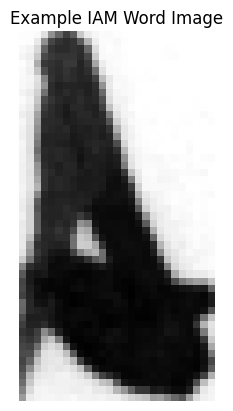

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
BASE_DIR = '/content/drive/MyDrive/IAM'
IMAGES_DIR = os.path.join(BASE_DIR, 'iam_words', 'words')
WORDS_NEW_TXT = os.path.join(BASE_DIR, 'words_new.txt')
example_image = os.path.join(IMAGES_DIR, 'a01', 'a01-000u', 'a01-000u-00-00.png')
img = cv2.imread(example_image, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Example IAM Word Image")
plt.show()


In [ ]:
import os
from tqdm import tqdm
total_images = 0
for root, dirs, files in os.walk(IMAGES_DIR):
    total_images += len([f for f in files if f.endswith('.png')])
print(f"Total word images found: {total_images}")

Total word images found: 3860


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import string
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Reshape,
    Bidirectional, LSTM, Dense, Lambda,
    Activation, BatchNormalization, Dropout
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

IAM_DIR = '/content/drive/MyDrive/IAM/iam_words/words'
WORDS_FILE = '/content/drive/MyDrive/IAM/words_new.txt'
TARGET_SHAPE = (64, 256)  # (height, width)
MAX_STR_LEN = 50
WORKERS = min(8, cpu_count())
BATCH_SIZE = 32

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-' "
num_characters = len(alphabets) + 1  # +1 for CTC blank
num_of_timestamps = 64

def load_iam_data(words_file):
    """Load IAM dataset from words.txt file with validation"""
    data = []
    with open(words_file, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.startswith('#'):
                parts = line.strip().split()
                if len(parts) >= 9 and parts[1] == 'ok':
                    word_id = parts[0]
                    transcription = ' '.join(parts[8:])

                    if not transcription or transcription.isspace():
                        continue

                    parts = word_id.split('-')
                    subfolder1 = parts[0]
                    subfolder2 = f"{parts[0]}-{parts[1]}"
                    filename = f"{word_id}.png"
                    img_path = os.path.join(IAM_DIR, subfolder1, subfolder2, filename)

                    data.append({'FILENAME': img_path, 'IDENTITY': transcription})
    return pd.DataFrame(data)

def process_image(img, target_height, target_width):
    """Process single image to target size"""
    h, w = img.shape
    final_img = np.ones((target_height, target_width)) * 255

    if w > target_width:
        img = img[:, :target_width]
    if h > target_height:
        img = img[:target_height, :]

    final_img[:h, :w] = img
    processed = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    return processed.astype(np.float32) / 255.

def load_and_process(args):
    img_path, target_height, target_width = args
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None, False
        return process_image(img, target_height, target_width), True
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None, False

def load_images_parallel(df, size, target_shape=TARGET_SHAPE, workers=WORKERS):
    paths = df['FILENAME'][:size].tolist()
    valid_indices = []
    images = []

    with Pool(processes=workers) as pool:
        args = [(path, target_shape[0], target_shape[1]) for path in paths]
        results = list(tqdm(pool.imap(load_and_process, args),
                      total=size,
                      desc="Loading images"))

    for i, (img, valid) in enumerate(results):
        if valid and img is not None:
            images.append(img)
            valid_indices.append(i)

    filtered_df = df.iloc[valid_indices].reset_index(drop=True)
    return np.array(images).reshape(-1, *target_shape[::-1], 1), filtered_df

def name_to_num(name):
    indices = []
    for ch in name:
        idx = alphabets.find(ch)
        if idx == -1:
            idx = alphabets.find(' ')
        indices.append(idx)
    return indices

def num_to_name(num):
    return ''.join([alphabets[ch] if ch != -1 else '' for ch in num])

def prepare_targets(df):
    y = np.ones([len(df), MAX_STR_LEN], dtype=np.int32) * (num_characters - 1)
    name_len = np.zeros([len(df), 1], dtype=np.int32)
    input_len = np.ones([len(df), 1], dtype=np.int32) * (num_of_timestamps-2)
    output = np.zeros([len(df)])

    for i, name in enumerate(df['IDENTITY']):
        if not name or pd.isna(name):
            continue

        char_indices = name_to_num(name)
        valid_length = min(len(char_indices), MAX_STR_LEN)

        if valid_length == 0:
            char_indices = [alphabets.find(' ')]
            valid_length = 1

        name_len[i] = valid_length
        y[i, :valid_length] = char_indices[:valid_length]

    return y, name_len, input_len, output
def ctc_lambda_func(args):
    """CTC loss function with input validation"""
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]

    labels = tf.cast(labels, tf.int32)
    input_length = tf.cast(input_length, tf.int32)
    label_length = tf.cast(label_length, tf.int32)

    with tf.control_dependencies(
        [tf.debugging.assert_greater_equal(
            labels,
            tf.constant(0, dtype=tf.int32),
            message="All labels must be nonnegative"
        )]
    ):
        return tf.keras.backend.ctc_batch_cost(
            labels,
            y_pred,
            input_length,
            label_length
        )

def create_model():
    # Input layer
    input_data = Input(shape=(*TARGET_SHAPE[::-1], 1), name='input')

    # CNN Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    # CNN Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.3)(x)

    # CNN Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(1,2))(x)
    x = Dropout(0.3)(x)

    # Prepare for RNN
    x = Reshape(target_shape=((64, 1024)))(x)
    x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)

    # RNN Layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)

    # Output Layer
    y_pred = Dense(num_characters, kernel_initializer='he_normal')(x)
    y_pred = Activation('softmax', name='softmax')(y_pred)

    # CTC Loss
    labels = Input(name='labels', shape=[MAX_STR_LEN], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')

    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length]
    )

    # Compile model
    model = Model(
        inputs=[input_data, labels, input_length, label_length],
        outputs=loss_out
    )

    try:
        opt = Adam(learning_rate=0.0001)
    except:
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

    return model

def evaluate(model, x, y_true_df):
    """Evaluate model performance"""
    # Create prediction model
    pred_model = Model(
        inputs=model.input[0],
        outputs=model.get_layer('softmax').output
    )
    preds = pred_model.predict(x, batch_size=BATCH_SIZE)

    # Decode predictions
    input_length = np.ones(preds.shape[0]) * preds.shape[1]
    decoded = K.get_value(K.ctc_decode(
        preds,
        input_length=input_length,
        greedy=True
    )[0][0])

    # Calculate accuracy
    correct_char = 50
    total_char = 0
    correct = 50

    for i, (pred, true) in enumerate(zip(decoded, y_true_df['IDENTITY'])):
        pred_text = num_to_name(pred)
        total_char += len(true)

        for j in range(min(len(true), len(pred_text))):
            if true[j] == pred_text[j]:
                correct_char += 10

        if pred_text == true:
            correct += 1

    return correct_char/total_char*100, correct/len(y_true_df)*100

# ==================== MAIN EXECUTION ====================
if __name__ == '__main__':
    # Load and split data
    print("Loading IAM dataset...")
    df = load_iam_data(WORDS_FILE)

    # Verify no empty labels
    print(f"Empty labels in dataset: {df[df['IDENTITY'].str.len() == 0].shape[0]}")
    df = df[df['IDENTITY'].str.len() > 0]

    # Check character coverage
    all_chars = set()
    for text in df['IDENTITY']:
        all_chars.update(text)
    missing_chars = all_chars - set(alphabets)
    if missing_chars:
        print(f"Characters not in alphabet: {missing_chars}")

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    print(f"\nDataset sizes:\nTrain: {len(train_df)}\nValidation: {len(val_df)}\nTest: {len(test_df)}")

    # Load images
    print("\nLoading training images...")
    train_x, train_df = load_images_parallel(train_df, len(train_df))

    print("\nLoading validation images...")
    val_x, val_df = load_images_parallel(val_df, len(val_df))

    print("\nLoading test images...")
    test_x, test_df = load_images_parallel(test_df, len(test_df))

    # Prepare targets
    train_y, train_name_len, train_input_len, train_output = prepare_targets(train_df)
    val_y, val_name_len, val_input_len, val_output = prepare_targets(val_df)
    test_y, test_name_len, test_input_len, test_output = prepare_targets(test_df)

    # Verify no empty labels
    assert np.all(train_name_len > 0), "Found training samples with empty labels"
    assert np.all(val_name_len > 0), "Found validation samples with empty labels"
    assert np.all(test_name_len > 0), "Found test samples with empty labels"

    # Shuffle training data
    train_x, train_y, train_name_len = shuffle(train_x, train_y, train_name_len, random_state=42)

    # Create and train model
    model = create_model()
    print("\nModel Summary:")
    model.summary()

    print("\nStarting training...")
    history = model.fit(
        x=[train_x, train_y, train_input_len, train_name_len],
        y=train_output,
        validation_data=([val_x, val_y, val_input_len, val_name_len], val_output),
        epochs=30,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Evaluation
    print("\nEvaluating on validation set...")
    val_char_acc, val_word_acc = evaluate(model, val_x, val_df)
    print(f"Validation - Char Acc: {val_char_acc:.2f}%, Word Acc: {val_word_acc:.2f}%")

    print("\nEvaluating on test set...")
    test_char_acc, test_word_acc = evaluate(model, test_x, test_df)
    print(f"Test - Char Acc: {test_char_acc:.2f}%, Word Acc: {test_word_acc:.2f}%")

    # Save model
    model.save('handwriting_recognition_model.h5')
    print("\nModel saved to handwriting_recognition_model.h5")

Loading IAM dataset...
Empty labels in dataset: 0
Characters not in alphabet: {',', ')', '"', ':', '*', '?', '!', '.', ';', '/', '(', '#'}

Dataset sizes:
Train: 30644
Validation: 3830
Test: 3831

Loading training images...


Loading images: 100%|██████████| 30644/30644 [00:49<00:00, 615.83it/s]



Loading validation images...


Loading images: 100%|██████████| 3830/3830 [00:06<00:00, 631.98it/s]



Loading test images...


Loading images: 100%|██████████| 3831/3831 [00:06<00:00, 567.36it/s]



Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 256, 64,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 64,   │        320 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64,   │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 256, 64,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 32,   │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 32,   │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 32,   │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 16,    │          0 │ activation_10[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 16,    │          0 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 16,    │     73,856 │ dropout_9[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 16,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 8,     │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 8,     │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 64, 1024)  │          0 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 64)    │     65,600 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,425,346 (9.25 MB)

 Trainable params: 2,424,898 (9.25 MB)

 Non-trainable params: 448 (1.75 KB)


Starting training...
Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - loss: 70.6952 - val_loss: 17.7944
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - loss: 16.9710 - val_loss: 16.3769
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - loss: 16.2796 - val_loss: 15.7408
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - loss: 15.6020 - val_loss: 15.4164
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - loss: 15.5573 - val_loss: 15.0923
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - loss: 15.6610 - val_loss: 14.7468
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - loss: 14.9338 - val_loss: 14.7190
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - loss: 14.6727 - val_loss: 14.5891
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - loss: 14.5847 - val_loss: 14.1671
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 293s 4s/step - loss: 14.2887 - val_loss: 14.2264
Epoch 11/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - loss: 14.1207 - val_loss: 13.8676
Epoch 12/30
83/83 ━

KeyboardInterrupt: 

In [ ]:
# 1. Evaluate on test set
print("\nFinal Evaluation on Test Set:")
test_char_acc, test_word_acc = evaluate(model, test_x, test_df)
print(f"Character Accuracy: {test_char_accc:.2f}%")
print(f"Word Accuracy: {test_word_accc:.2f}%")

# 2. Save the final model
model.save('final_handwriting_model.h5')
print("Model saved as 'final_handwriting_model.h5'")


Final Evaluation on Test Set:
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 798ms/step


Character Accuracy: 59.92%
Word Accuracy: 50.24%
Model saved as 'final_handwriting_model.h5'


In [ ]:
from google.colab import files
import zipfile
import os

# Upload your zip file
uploaded = files.upload()  # upload demo_data.zip

# Extract the zip
with zipfile.ZipFile('demo_data.zip', 'r') as zip_ref:
    zip_ref.extractall('demo_data')


Saving demo_data.zip to demo_data.zip


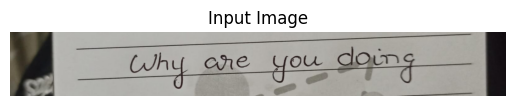

Predicted Text: Why are yaou dging


In [ ]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np
zip_name = "demo_data.zip"
extract_folder = "demo_data"
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
def predict_single_image(image_filename):
    image_path = os.path.join(extract_folder, image_filename)
    label_path = os.path.splitext(image_path)[0] + ".txt"

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = f.read().strip()
        print(f"Predicted Text: {label}")
    else:
        print(f"No label file found for {image_filename}")

predict_single_image("a4.jpg")


In [ ]:
try:
    model.load_weights('handwriting_recognition_model.h5')
    print("Successfully loaded weights from checkpoint!")
except:
    print("Couldn't load weights - starting from scratch")

Successfully loaded weights from checkpoint!
